# Imports

In [1]:
import pandas as pd
import sklearn as sk
import scipy
import numpy as np
import pickle

In [2]:
# Import data
df = pd.read_csv('data/maindata_small.csv')

# First Glance and Set creation

In [3]:
df.head()

,Unnamed: 0,V1,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
0,1,1263097,2019-05-04 05:11:26,BARCELONA,MADRID,2019-05-16 06:25:00,2019-05-16 08:55:00,AVE,78.80,Turista,Promo
1,2,1980371,2019-04-15 02:28:14,VALENCIA,MADRID,2019-05-25 14:50:00,2019-05-25 22:17:00,REGIONAL,28.35,Turista,Adulto ida
2,3,1595459,2019-05-09 21:02:40,MADRID,SEVILLA,2019-06-24 15:00:00,2019-06-24 17:21:00,AVE,41.20,Turista,Promo
3,4,1126882,2019-05-01 13:16:14,MADRID,VALENCIA,2019-05-15 15:10:00,2019-05-15 16:52:00,AVE,21.95,Turista,Promo
4,5,688748,2019-04-24 08:11:56,BARCELONA,MADRID,2019-05-08 13:25:00,2019-05-08 16:10:00,AVE,85.10,Turista,Promo


In [4]:
# How many NAs
df.isna().sum()

Unnamed: 0        0
V1                0
insert_date       0
origin            0
destination       0
start_date        0
end_date          0
train_type        0
price          1231
train_class      41
fare             41
dtype: int64

In [5]:
# Length of the dataset
len(df)

10000

In [6]:
# Proportion of missing price values
df.isna().sum()['price'] / len(df)

0.1231

# Feature engineering and set creation

In [7]:
import datetime as dt
import time

In [8]:
# Convert date strings
df['insert_date'] = pd.to_datetime(df['insert_date'],
                                        infer_datetime_format=True)
df['start_date'] = pd.to_datetime(df['start_date'],
                                        infer_datetime_format=True)
df['end_date'] = pd.to_datetime(df['end_date'],
                                        infer_datetime_format=True)

In [9]:
# Time between end and start
df['traveltime'] = df['end_date'] - df['start_date']

In [10]:
# traveltime in minutes
temp1 = df['traveltime'].apply(lambda x: str(x))
timestring = temp1.replace(to_replace=r'0 days ', value='', regex=True)

In [11]:
# Convert timestring to seconds
def get_sec(time_str):
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

df['traveltime_seconds'] = timestring.apply(lambda x: get_sec(x))
df['traveltime_seconds']

0        9000
1       26820
2        8460
3        6120
4        9900
5        9000
6        8820
7       24180
8       10500
9       22920
10       9480
11      10200
12       9600
13       9000
14      10080
15       9120
16      13980
17       9000
18       9000
19      15360
20      15000
21       9000
22      11400
23       6420
24      10320
25       9120
26       8460
27       6540
28      18000
29       9360
        ...  
9970     9600
9971     9480
9972     9120
9973     8460
9974     9120
9975     9000
9976    11400
9977     9960
9978    10320
9979    11400
9980    33720
9981    26040
9982     6000
9983    32640
9984     8700
9985     9120
9986     9000
9987     9000
9988     6240
9989     8700
9990     9480
9991     6000
9992     9000
9993     9720
9994     9360
9995     9000
9996     6000
9997    25140
9998     9000
9999     6000
Name: traveltime_seconds, Length: 10000, dtype: int64

In [12]:
# Weekday variable - start date and end date weekdays
df['insert_day'] = df['insert_date'].dt.day_name()
df['start_day'] = df['start_date'].dt.day_name()
df['end_day'] = df['end_date'].dt.day_name()

In [13]:
# Month variable
df['insert_month'] = df['insert_date'].dt.month_name()
df['start_month'] = df['start_date'].dt.month_name()
df['end_month'] = df['end_date'].dt.month_name()

In [14]:
# drop dates
df = df.drop(['insert_date', 'start_date', 'end_date'], axis=1)

In [15]:
# Missing values will make our prediction set
df_work = df[df.price.notna()]
df_goal = df[df.price.isna()]

In [16]:
len(df_work)

8769

In [17]:
len(df_goal)

1231

In [18]:
# Check if it worked correctly
(len(df) == len(df_goal) + len(df_work))

True

In [19]:
# Another check
(df_work.price.notna().sum() == len(df_work)) and (df_goal.price.isna().sum() == len(df_goal))

True

In [20]:
# Which train classes are there?
df.train_class.unique()

array(['Turista', 'Preferente', 'Turista Plus', 'Turista con enlace', nan,
       'Cama G. Clase', 'Cama Turista'], dtype=object)

# Visual Analysis

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# set plot size for jupyter notebook
plt.rcParams['figure.figsize'] = [10, 5]

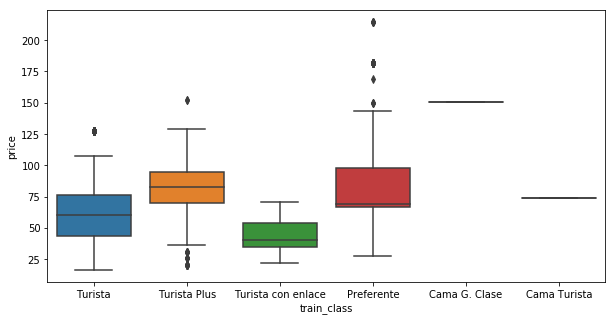

In [23]:
# Price and class
pc = sns.boxplot(x="train_class", y="price", data=df_work)

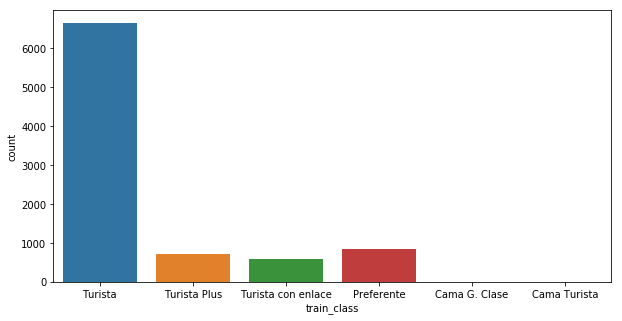

In [24]:
# bar plot on train class count
tcc = sns.countplot(data=df_work, x="train_class")

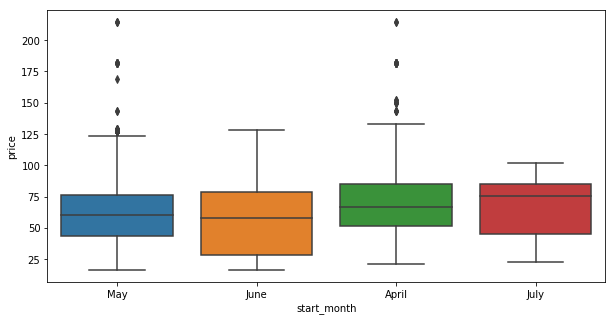

In [25]:
# Travel prices per month
tpm = sns.boxplot(x="start_month", y="price", data=df_work)

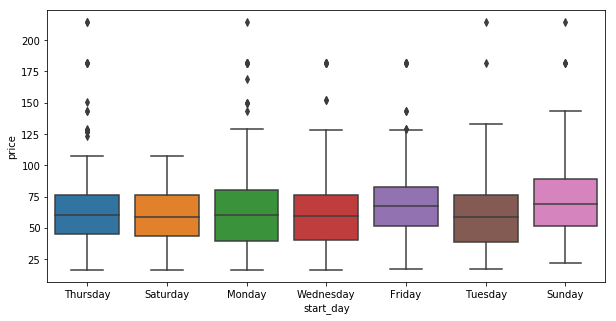

In [26]:
# Travel prices per day
tpd = sns.boxplot(x="start_day", y="price", data=df_work)

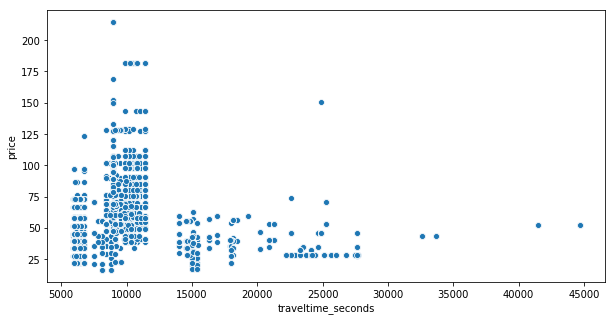

In [27]:
# price by travel time
ptt = sns.scatterplot(x="traveltime_seconds", y="price", data=df_work)

# One-Hot-Encoding

In [28]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [29]:
# Wich values need to be OH-encoded?
    # origin
    # destination
    # train_type
    # train_class
    # fare
    # insert_day
    # start_day
    # end_day
    # insert_month
    # start_month
    # end_month

In [30]:
# state encoder
oh_encoder = OneHotEncoder(sparse=False)

In [31]:
# checking types
df_work.dtypes

Unnamed: 0                      int64
V1                              int64
origin                         object
destination                    object
train_type                     object
price                         float64
train_class                    object
fare                           object
traveltime            timedelta64[ns]
traveltime_seconds              int64
insert_day                     object
start_day                      object
end_day                        object
insert_month                   object
start_month                    object
end_month                      object
dtype: object

In [32]:
# changing column types for df_work and df_goal


obj_to_cat = ['origin', 'destination', 'train_type', 'train_class', 'fare',
              'insert_day', 'start_day', 'end_day', 'insert_month',
              'start_month', 'end_month']

for col in obj_to_cat:
    df_work[col] = df_work[col].astype('category')

for col in obj_to_cat:
    df_goal[col] = df_goal[col].astype('category')

C:\Users\cholz\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\cholz\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [33]:
# dropping traveltime
df_work = df_work.drop(['traveltime'], axis=1)
df_goal = df_goal.drop(['traveltime'], axis=1)

In [34]:
# oh-encoding
df_work_oh = pd.get_dummies(df_work)
df_goal_oh = pd.get_dummies(df_goal)

# Splits

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
# Dividing training set into X and y
X = df_work_oh.drop('price', axis=1)
y = df_work_oh.price

In [37]:
# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression

In [38]:
# import
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [39]:
# base model
linreg = LinearRegression()

In [40]:
# fitting
#linearmodel = linreg.fit(X_train, y_train)

# Load the model instead of fitting it each time
linearmodel = pickle.load(open('linearmodel.sav', 'rb'))

In [41]:
# print results
print(linearmodel.intercept_)
print(linearmodel.coef_)

71.21760736113471
[-1.93717745e-05 -1.04827436e-07 -7.74585015e-04  2.69655536e+01
 -3.65301895e-01 -1.01961701e+01 -2.87156512e+00 -1.35325165e+01
  2.83226986e+01  3.65301895e-01 -1.34713890e+01 -2.04405229e+00
 -1.31725592e+01  4.86393111e-01  2.82550034e+00  8.31156735e+00
  3.47079587e+00  6.90562787e+00  7.92067507e+00 -3.57437155e+00
 -5.64372764e-01 -5.54704523e+00  3.80323242e+00 -5.21675866e+00
 -6.85618110e+00 -1.35749245e+01  6.61966484e+00 -5.00980310e+00
 -2.70450329e-12 -1.45661261e-13  1.36683613e+01 -9.08373713e+00
 -5.79922596e-01 -4.00470159e+00 -6.95525963e+00  1.84013297e+01
 -1.55875313e-12 -1.08257101e+01 -6.20359990e-01  3.24594561e-02
  3.10513243e-01 -1.23377102e-01 -3.23552939e-01 -1.58439736e-01
 -9.73848303e-02  3.59781908e-01 -2.88376476e+00  4.05518397e-01
 -4.15618868e+00  8.89733911e+00 -1.60151220e+00  3.47525047e+00
 -4.13664234e+00  4.96442352e+00 -1.05981404e+00  1.84685194e+00
 -6.32157552e+00  1.67473546e+00 -5.14701510e+00  4.04239374e+00
 -5.515

In [42]:
# imports for p-values
import statsmodels.api as sm

In [43]:
# calculate p-values
mod = sm.OLS(y_train, X_train)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']

In [44]:
p_values <= 0.05

Unnamed: 0                   False
V1                           False
traveltime_seconds            True
origin_BARCELONA              True
origin_MADRID                 True
origin_PONFERRADA             True
origin_SEVILLA               False
origin_VALENCIA               True
destination_BARCELONA         True
destination_MADRID            True
destination_PONFERRADA        True
destination_SEVILLA           True
destination_VALENCIA          True
train_type_ALVIA              True
train_type_AV City            True
train_type_AVE                True
train_type_AVE-LD             True
train_type_AVE-MD             True
train_type_AVE-TGV            True
train_type_INTERCITY         False
train_type_LD                False
train_type_LD-MD              True
train_type_MD                False
train_type_MD-AVE            False
train_type_MD-LD              True
train_type_R. EXPRES          True
train_type_REGIONAL           True
train_type_TRENHOTEL         False
train_class_Cama G. 

In [45]:
# Make a test prediction
predlin = linearmodel.predict(X_test)

In [46]:
# MSE
print("Mean squared error: %.2f"
      % mean_squared_error(predlin, y_test))

Mean squared error: 129.19


In [47]:
# RMSE
print("RMSE: %.2f"
      % np.sqrt(mean_squared_error(predlin, y_test)))

RMSE: 11.37


In [48]:
# RSQUARED
print('R_squared: %.2f' % r2_score(predlin, y_test))

R_squared: 0.77


In [49]:
# Calculate mean absolute percentage error (MAPE)
lmerrors = abs(predlin - y_test)
lmmape = 100 * (lmerrors / y_test)

In [50]:
# Calculate and display accuracy
lmaccuracy = 100 - np.mean(lmmape)
print('Accuracy:', round(lmaccuracy, 2), '%.')

Accuracy: 86.31 %.


In [51]:
# save model to disk
filename = 'linearmodel.sav'
pickle.dump(linearmodel, open(filename, 'wb'))

# Random Forest

In [52]:
from sklearn.ensemble import RandomForestRegressor

In [53]:
# Instantiate model with 200 decision trees
rf = RandomForestRegressor(n_estimators = 200, random_state = 123)

In [54]:
# Train the model on training data
# rfmodel = rf.fit(X_train, y_train)

# Load the model instead of fitting it each time
rfmodel = pickle.load(open('rfmodel.sav', 'rb'))

In [55]:
# predict training data
predrf = rfmodel.predict(X_test)

In [56]:
# MSE
print("Mean squared error: %.2f"
      % mean_squared_error(predrf, y_test))

Mean squared error: 85.07


In [57]:
# RMSE
print("RMSE: %.2f"
      % np.sqrt(mean_squared_error(predrf, y_test)))

RMSE: 9.22


In [58]:
# RSQUARED
print('R_squared: %.2f' % r2_score(predrf, y_test))

R_squared: 0.87


In [59]:
# Calculate mean absolute percentage error (MAPE)
rferrors = abs(predrf - y_test)
rfmape = 100 * (rferrors / y_test)

In [60]:
# Calculate and display accuracy
rfaccuracy = 100 - np.mean(rfmape)
print('Accuracy:', round(rfaccuracy, 2), '%.')

Accuracy: 90.52 %.


In [61]:
from sklearn.feature_selection import SelectFromModel

In [62]:
# Make column name list
feature_names = list(X_train.columns)

In [63]:
# Print the name and gini importance of each feature
for feature in zip(feature_names, rfmodel.feature_importances_):
    print(feature)

('Unnamed: 0', 0.028788079151918673)
('V1', 0.026837246915306312)
('traveltime_seconds', 0.48070592043546073)
('origin_BARCELONA', 0.0442343394055756)
('origin_MADRID', 0.0012797064354426915)
('origin_PONFERRADA', 2.1097446496883508e-05)
('origin_SEVILLA', 0.04123149021886489)
('origin_VALENCIA', 0.005368224117470505)
('destination_BARCELONA', 0.039548872547334274)
('destination_MADRID', 0.0013826133553846958)
('destination_PONFERRADA', 0.00022260077498834462)
('destination_SEVILLA', 0.04685878395676649)
('destination_VALENCIA', 0.0005865077151811979)
('train_type_ALVIA', 0.010989243141256003)
('train_type_AV City', 0.0005244390854982758)
('train_type_AVE', 0.016431468511532682)
('train_type_AVE-LD', 5.04444043649971e-05)
('train_type_AVE-MD', 0.001807033991459208)
('train_type_AVE-TGV', 0.0020228230794691274)
('train_type_INTERCITY', 0.0022022988024666596)
('train_type_LD', 2.054557481918553e-05)
('train_type_LD-MD', 0.00023419615800758322)
('train_type_MD', 2.6240062696361262e-05)
('

In [64]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.01
sfm = SelectFromModel(rfmodel, threshold=0.01)

In [65]:
# Train the selector
sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=123, verbose=0, warm_start=False),
        max_features=None, norm_order=1, prefit=False, threshold=0.01)

In [66]:
# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(feature_names[feature_list_index])

Unnamed: 0
V1
traveltime_seconds
origin_BARCELONA
origin_SEVILLA
destination_BARCELONA
destination_SEVILLA
train_type_ALVIA
train_type_AVE
train_class_Preferente
train_class_Turista
fare_Flexible
fare_Promo


In [67]:
# DATA SUBSET WITH ONLY THE IMPORTANT FEATURES

# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

In [68]:
# save model to disk
filename = 'rfmodel.sav'
pickle.dump(rfmodel, open(filename, 'wb'))

# XGBoost

In [69]:
import xgboost
from sklearn.metrics import explained_variance_score

In [70]:
# State the model
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

# Load the model instead of fitting it each time
rfmodel = pickle.load(open('xgbmodel.sav', 'rb'))

[19:29:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [71]:
# Train the model
# xgbmodel = xgb.fit(X_train, y_train)

# Load the model instead of fitting it each time
xgbmodel = pickle.load(open('xgbmodel.sav', 'rb'))

[19:29:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [72]:
# Make predictions
xgbpred = xgbmodel.predict(X_test)

In [73]:
# RSQUARED
print(explained_variance_score(xgbpred, y_test))

0.8640318986854577


In [74]:
# MSE
print("Mean squared error: %.2f"
      % mean_squared_error(xgbpred, y_test))

Mean squared error: 82.87


In [75]:
# RMSE
print("RMSE: %.2f"
      % np.sqrt(mean_squared_error(xgbpred, y_test)))

RMSE: 9.10


In [76]:
# RSQUARED
print('R_squared: %.2f' % r2_score(xgbpred, y_test))

R_squared: 0.86


In [77]:
# Calculate mean absolute percentage error (MAPE)
xgberrors = abs(xgbpred - y_test)
xgbmape = 100 * (xgberrors / y_test)

In [78]:
# Calculate and display accuracy
xgbaccuracy = 100 - np.mean(xgbmape)
print('Accuracy:', round(xgbaccuracy, 2), '%.')

Accuracy: 90.04 %.


In [79]:
# save model to disk
filename = 'xgbmodel.sav'
pickle.dump(xgbmodel, open(filename, 'wb'))

# XGBoost Grid Search on the test/train

In [80]:
# READ THIS
    # https://www.datacamp.com/community/tutorials/xgboost-in-python

In [81]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st

In [82]:
# State the model
xgbgs = xgboost.XGBRegressor()

In [83]:
# Preparing parameter grid
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 100)

params = {  
    "n_estimators": st.randint(3, 200),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.1),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

params2 = {
    "n_estimators": st.randint(3, 400),
    "max_depth": st.randint(3, 100),
    "learning_rate": st.uniform(0.05, 0.3),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 0.2),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

In [84]:
# Instantiating randomized grid search
gs = RandomizedSearchCV(xgbgs, params2, n_jobs=5, cv=5)  

In [85]:
# Fitting the model and the grid
gs.fit(X_train, y_train)

C:\Users\cholz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=5,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000150F3955E48>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000150F395F780>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000150F395F908>, 'cols...D0>, 'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000150F39551D0>},


In [86]:
# Displaying best parameters
bestxgb_params = gs.best_params_
bestxgb_params

{'colsample_bytree': 0.5865476040510835,
 'gamma': 0.021409201541408643,
 'learning_rate': 0.1655741121046589,
 'max_depth': 10,
 'min_child_weight': 6.204736454046467,
 'n_estimators': 250,
 'reg_alpha': 280.0811761984805,
 'subsample': 0.8715124921538038}

In [87]:
# New model
xgb_best = xgboost.XGBRegressor(colsample_bytree=0.7986306694454575,
 gamma=0.008783023184115057,
 learning_rate=0.1522743685057763,
 max_depth=46,
 min_child_weight=61.276714293435155,
 n_estimators=388,
 reg_alpha=95.34130218741632,
 subsample=0.9695758721284863)

In [88]:
# Train the model
#xgb2_model = xgb_best.fit(X_train, y_train)

In [89]:
# save model to disk
#filename = 'xgb2_model.sav'
#pickle.dump(xgb2_model, open(filename, 'wb'))

In [90]:
# Load the model instead of fitting it each time
xgb2_model = pickle.load(open('xgb2_model.sav', 'rb'))

[19:32:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [91]:
# Make predictions
xgb2pred = xgb2_model.predict(X_test)

In [92]:
# RSQUARED
print(explained_variance_score(xgb2pred, y_test))

0.8564662445487086


In [93]:
# MSE
print("Mean squared error: %.2f"
      % mean_squared_error(xgb2pred, y_test))

Mean squared error: 89.22


In [94]:
# RMSE
print("RMSE: %.2f"
      % np.sqrt(mean_squared_error(xgb2pred, y_test)))

RMSE: 9.45


In [95]:
# RSQUARED
print('R_squared: %.2f' % r2_score(xgb2pred, y_test))

R_squared: 0.86


In [96]:
# Calculate mean absolute percentage error (MAPE)
xgb2errors = abs(xgb2pred - y_test)
xgb2mape = 100 * (xgb2errors / y_test)

In [97]:
# Calculate and display accuracy
xgb2accuracy = 100 - np.mean(xgb2mape)
print('Accuracy:', round(xgb2accuracy, 2), '%.')

Accuracy: 89.32 %.


In [98]:
# We overfitted the model. Let's try XGBoost with Cross Validation next.

# XGBoost Cross Validation

In [99]:
# documentation here:
    # https://scikit-learn.org/stable/modules/cross_validation.html

In [100]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [101]:
# Evaluating base model vs grid model
scores_base = cross_val_score(xgbmodel, X_train, y_train, cv=5)
scores_grid = cross_val_score(xgb2_model, X_train, y_train, cv=5)

[19:32:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\cholz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\cholz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\cholz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\cholz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\cholz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\cholz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:33:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\cholz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:33:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\cholz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:33:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\cholz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:34:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\cholz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:34:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [102]:
print("Accuracy Base Model: %0.2f (+/- %0.2f)" % (scores_base.mean(), scores_base.std() * 2))
print("Accuracy Grid Model: %0.2f (+/- %0.2f)" % (scores_grid.mean(), scores_grid.std() * 2))

Accuracy Base Model: 0.89 (+/- 0.01)
Accuracy Grid Model: 0.88 (+/- 0.01)


# Neural Network

In [144]:
import numpy as np
import itertools
import keras
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [145]:
tbCallBack = keras.callbacks.TensorBoard(log_dir='graphs', histogram_freq=0,
                                         write_graph=True, write_images=True)

In [104]:
# Usually it's a good practice to apply following formula in order to find out the total number
# of hidden layers needed.

# Nh = Ns/(α∗ (Ni + No))

# where
    # Ni = number of input neurons.
    # No = number of output neurons.
    # Ns = number of samples in training data set.
    # α = an arbitrary scaling factor usually 2-10.

nh = round(len(X_train)/(7 * (X_train.shape[1] + 1)))
nh

14

In [105]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

C:\Users\cholz\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\cholz\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\cholz\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  """


In [106]:
# Initialising the ANN
nn = Sequential()

# Adding the input layer and the first hidden layer
nn.add(Dense(70, activation = 'relu', input_dim = 70))
nn.add(BatchNormalization())

# Adding 14 hidden layers
for i in range(14): 
    nn.add(Dense(units = 70, activation = 'relu'))

# Adding the output layer
nn.add(Dense(units = 1))

#model.add(Dense(1))
# Compiling the ANN
nn.compile(optimizer = 'adam', loss = 'mean_squared_error')

W0828 19:35:06.908272 12528 deprecation_wrapper.py:119] From C:\Users\cholz\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0828 19:35:06.946031 12528 deprecation_wrapper.py:119] From C:\Users\cholz\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0828 19:35:06.946031 12528 deprecation_wrapper.py:119] From C:\Users\cholz\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0828 19:35:07.061986 12528 deprecation_wrapper.py:119] From C:\Users\cholz\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0828 19:35:07.463090 12528 deprecation_wrappe

In [146]:
# Fitting the ANN to the Training set
nnmodel = nn.fit(X_train_sc, y_train, batch_size = 32, epochs = 100,
                 callbacks = [tbCallBack])

# Load the model instead of fitting it each time
#nnmodel = pickle.load(open('nnmodel.sav', 'rb'))

W0828 19:58:49.404351 12528 deprecation_wrapper.py:119] From C:\Users\cholz\Anaconda3\lib\site-packages\keras\callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0828 19:58:49.404351 12528 deprecation_wrapper.py:119] From C:\Users\cholz\Anaconda3\lib\site-packages\keras\callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/100
7015/7015 [==============================] - 1s 129us/step - loss: 43.0029
Epoch 2/100
7015/7015 [==============================] - 1s 131us/step - loss: 42.1823
Epoch 3/100
7015/7015 [==============================] - 1s 129us/step - loss: 42.1498
Epoch 4/100
7015/7015 [==============================] - 1s 134us/step - loss: 45.8577
Epoch 5/100
7015/7015 [==============================] - 1s 138us/step - loss: 40.4937
Epoch 6/100
7015/7015 [==============================] - 1s 145us/step - loss: 41.0480
Epoch 7/100
7015/7015 [==============================] - 1s 158us/step - loss: 39.9738
Epoch 8/100
7015/7015 [==============================] - 1s 147us/step - loss: 39.5695
Epoch 9/100
7015/7015 [==============================] - 1s 165us/step - loss: 40.4217
Epoch 10/100
7015/7015 [==============================] - 1s 154us/step - loss: 40.8567
Epoch 11/100
7015/7015 [==============================] - 1s 154us/step - loss: 40.2977
Epoch 12/100
7015/7015 [=================

7015/7015 [==============================] - 1s 131us/step - loss: 29.1031
Epoch 95/100
7015/7015 [==============================] - 1s 131us/step - loss: 30.9124
Epoch 96/100
7015/7015 [==============================] - 1s 131us/step - loss: 28.9461
Epoch 97/100
7015/7015 [==============================] - 1s 134us/step - loss: 31.6832
Epoch 98/100
7015/7015 [==============================] - 1s 134us/step - loss: 29.7554
Epoch 99/100
7015/7015 [==============================] - 1s 136us/step - loss: 29.3805
Epoch 100/100
7015/7015 [==============================] - 1s 131us/step - loss: 31.5041


In [108]:
# Make predictions
nnpred = nn.predict(X_test_sc)

In [109]:
nnpred

array([[32.44138 ],
       [31.982714],
       [41.787285],
       ...,
       [79.96075 ],
       [45.30657 ],
       [23.950497]], dtype=float32)

In [110]:
# transform predictions back
nnpred = nnpred.flatten()
nnpred = pd.Series(nnpred)

In [111]:
# RSQUARED
print(explained_variance_score(nnpred, y_test))

0.8225478198294838


In [112]:
# MSE
print("Mean squared error: %.2f"
      % mean_squared_error(nnpred, y_test))

Mean squared error: 115.43


In [113]:
# RMSE
print("RMSE: %.2f"
      % np.sqrt(mean_squared_error(nnpred, y_test)))

RMSE: 10.74


In [114]:
# RSQUARED
print('R_squared: %.2f' % r2_score(nnpred, y_test))

R_squared: 0.81


In [115]:
# Calculate mean absolute percentage error (MAPE)
nnerrors = abs(nnpred - y_test)
nnmape = 100 * (nnerrors / y_test)

In [116]:
# Calculate and display accuracy
nnaccuracy = 100 - np.mean(nnmape)
print('Accuracy:', round(nnaccuracy, 2), '%.')

Accuracy: 45.53 %.


In [117]:
# save model to disk
filename = 'nnmodel.sav'
pickle.dump(nnmodel, open(filename, 'wb'))

# Plotting all predictions

In [118]:
import seaborn as sns

In [119]:
predplot = pd.DataFrame({'real data': y_test,
                         'linear model': predlin,
                         'random forest': predrf,
                         'xgboost': xgbpred,
                         'xgboost gridsearch': xgb2pred,
                         'neural network': nnpred.values
                        })

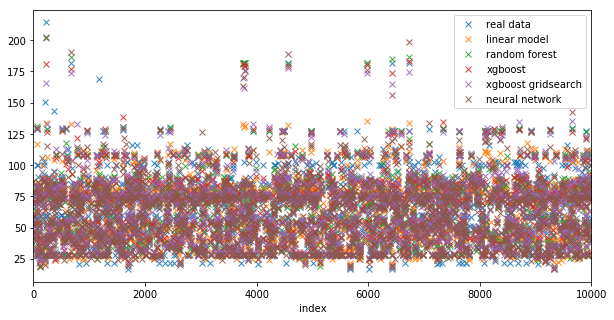

In [120]:
predplot.reset_index().plot(x='index',
                            y=['real data', 'linear model',
                               'random forest', 'xgboost',
                               'xgboost gridsearch', 'neural network'],
                            linestyle='none',
                            marker='x',
                            alpha=.9)

# Combining the predictions into a new model

In [121]:
# import
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [122]:
# predict the train sets with our models
linx = linearmodel.predict(X_train)
rfx = rfmodel.predict(X_train)
xgbx = xgbmodel.predict(X_train)
xgb2x = xgb2_model.predict(X_train)
nnx = nn.predict(X_train)

# transform predictions back
nnx = nnx.flatten()
nnx = pd.Series(nnx)

In [123]:
lindf = pd.DataFrame({   'linear model': linx,
                         'random forest': rfx,
                         'xgboost': xgbx,
                         'xgboost gridsearch': xgb2x,
                         'neural network': nnx
                        })

In [124]:
lindf2 = pd.DataFrame({ 'linear model': predlin,
                        'random forest': predrf,
                        'xgboost': xgbpred,
                        'xgboost gridsearch': xgb2pred,
                        'neural network': nnpred
                    })

In [125]:
# base model
linreg = LinearRegression()

In [126]:
# fit the model
stackedmodel = linreg.fit(lindf, y_train)

In [127]:
# print results - these will be used as weights later
print(stackedmodel.intercept_)
print(stackedmodel.coef_)

-0.1099297994943953
[-2.95174445e-01  2.11620919e-01  2.11620919e-01  8.73986121e-01
 -4.69033605e-08]


In [128]:
# simple average, without NN
lindf2['avg'] = lindf2.mean(axis=1)
lindf2pred = lindf2['avg']

In [129]:
# MSE
print("Mean squared error: %.2f"
      % mean_squared_error(lindf2pred, y_test))

Mean squared error: 85.28


In [130]:
# RMSE
print("RMSE: %.2f"
      % np.sqrt(mean_squared_error(lindf2pred, y_test)))

RMSE: 9.23


In [131]:
# RSQUARED
print('R_squared: %.2f' % r2_score(lindf2pred, y_test))

R_squared: 0.86


In [132]:
# Calculate mean absolute percentage error (MAPE)
lindf2errors = abs(lindf2pred - y_test)
lindf2mape = 100 * (lindf2errors / y_test)

In [133]:
# Calculate and display accuracy
lindf2accuracy = 100 - np.mean(lindf2mape)
print('Accuracy:', round(lindf2accuracy, 2), '%.')

Accuracy: 44.66 %.


In [134]:
# save predictions to disk
filename = 'lindf2pred.sav'
pickle.dump(lindf2pred, open(filename, 'wb'))

In [135]:
# weighted averages:
linw = pd.DataFrame()
linw['linear model'] = lindf2['linear model']*-2.95190820e-01
linw['random forest'] = lindf2['random forest']*2.11623261e-01
linw['xgboost'] = lindf2['xgboost']*2.11623261e-01
linw['xgboost gridsearch'] = lindf2['xgboost gridsearch']*8.73981514e-01
linw['neural network'] = lindf2['neural network']*-1.60194429e-06

In [136]:
# weighted average, without NN
linw['avg'] = -0.10883479972148535 + linw['linear model'] + linw['random forest'] + linw['xgboost'] + linw['xgboost gridsearch'] + linw['neural network']
linwpred = linw['avg']

In [137]:
# MSE
print("Mean squared error: %.2f"
      % mean_squared_error(linwpred, y_test))

Mean squared error: 87.99


In [138]:
# RMSE
print("RMSE: %.2f"
      % np.sqrt(mean_squared_error(linwpred, y_test)))

RMSE: 9.38


In [139]:
# RSQUARED
print('R_squared: %.2f' % r2_score(linwpred, y_test))

R_squared: 0.87


In [140]:
# Calculate mean absolute percentage error (MAPE)
linwerrors = abs(linwpred - y_test)
linwmape = 100 * (linwerrors / y_test)

In [141]:
# Calculate and display accuracy
linwaccuracy = 100 - np.mean(linwmape)
print('Accuracy:', round(linwaccuracy, 2), '%.')

Accuracy: 43.76 %.


In [142]:
lindf2

,linear model,random forest,xgboost,xgboost gridsearch,neural network,avg
0,40.989573,36.96300,37.379406,35.849976,32.441380,36.724667
1,40.703901,35.59750,38.045025,39.805588,31.982714,37.226946
2,45.217880,43.25000,43.426487,43.074169,41.787285,43.351164
3,41.718151,34.95175,34.368744,35.175423,37.002026,36.643219
4,77.999041,77.67375,77.425713,75.357376,69.570740,75.605324
5,30.965276,28.35000,27.922184,26.747303,28.238514,28.444655
6,63.649020,66.35825,66.243202,65.071617,65.260567,65.316531
7,104.143938,94.34425,90.876656,94.844688,86.786407,94.199188
8,89.075986,92.94725,94.163948,92.977112,89.782387,91.789336
9,27.325038,28.35000,27.970875,28.107878,28.339046,28.018567
